In [2]:
from __future__ import print_function, division,absolute_import
import pypsa
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Wedge, Rectangle, Circle

# Original Vietnam Model vs Renewables Ninja

## Original Vietnam Model

### Load Original Model with original data and fix Solar and Hydro Data

In [4]:
csv_folder_name = "/home/schlott/Vietnam/ReVietSys/original-model_original_data/"
network = pypsa.Network(csv_folder_name)

for bus in network.buses.index.drop(['HiepHoa', 'LaiChauH', 'DongAnh', 'SonLa', 'VungAng']):
    temp = network.generators_t.p_max_pu[bus+' solar'].copy()
    network.generators_t.p_max_pu[bus+' solar'] = network.generators_t.p_max_pu[bus+' hydro'].copy()
    network.generators_t.p_max_pu[bus+' hydro'] = temp.copy()

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads


### Load Original Model with point-wise Wind and Solar Data from RenewablesNinja

In [9]:
csv_folder_name = "/home/schlott/Vietnam/ReVietSys/original-model_ninja-data/"
ninja = pypsa.Network(csv_folder_name)

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads


### Time series comparison of Wind and Solar generation

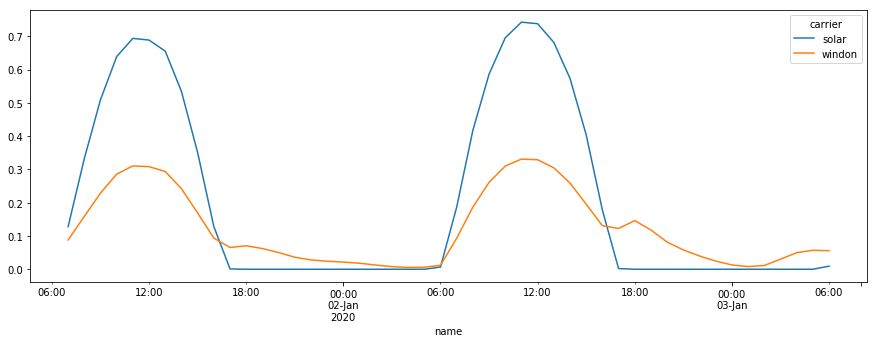

In [4]:
fig, ax = plt.subplots(figsize=(15,5))

network.generators_t.p_max_pu.groupby([network.generators.carrier], axis=1).mean().iloc[0:48] \
       .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).drop(columns='hydro').plot(ax=ax)

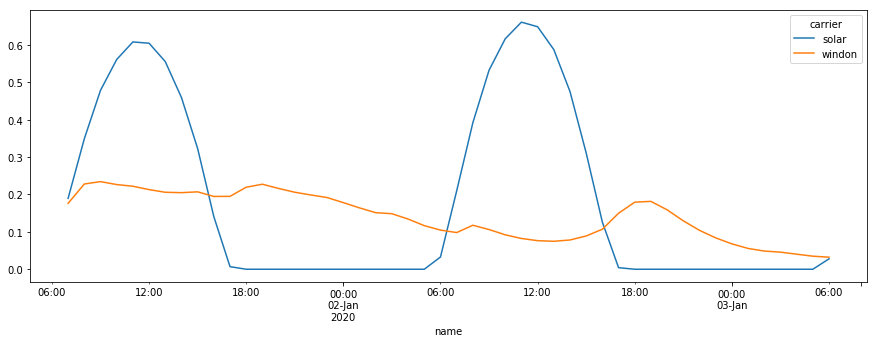

In [5]:
fig, ax = plt.subplots(figsize=(15,5))

ninja.generators_t.p_max_pu.groupby([ninja.generators.carrier], axis=1).mean().iloc[0:48] \
     .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).plot(ax=ax)

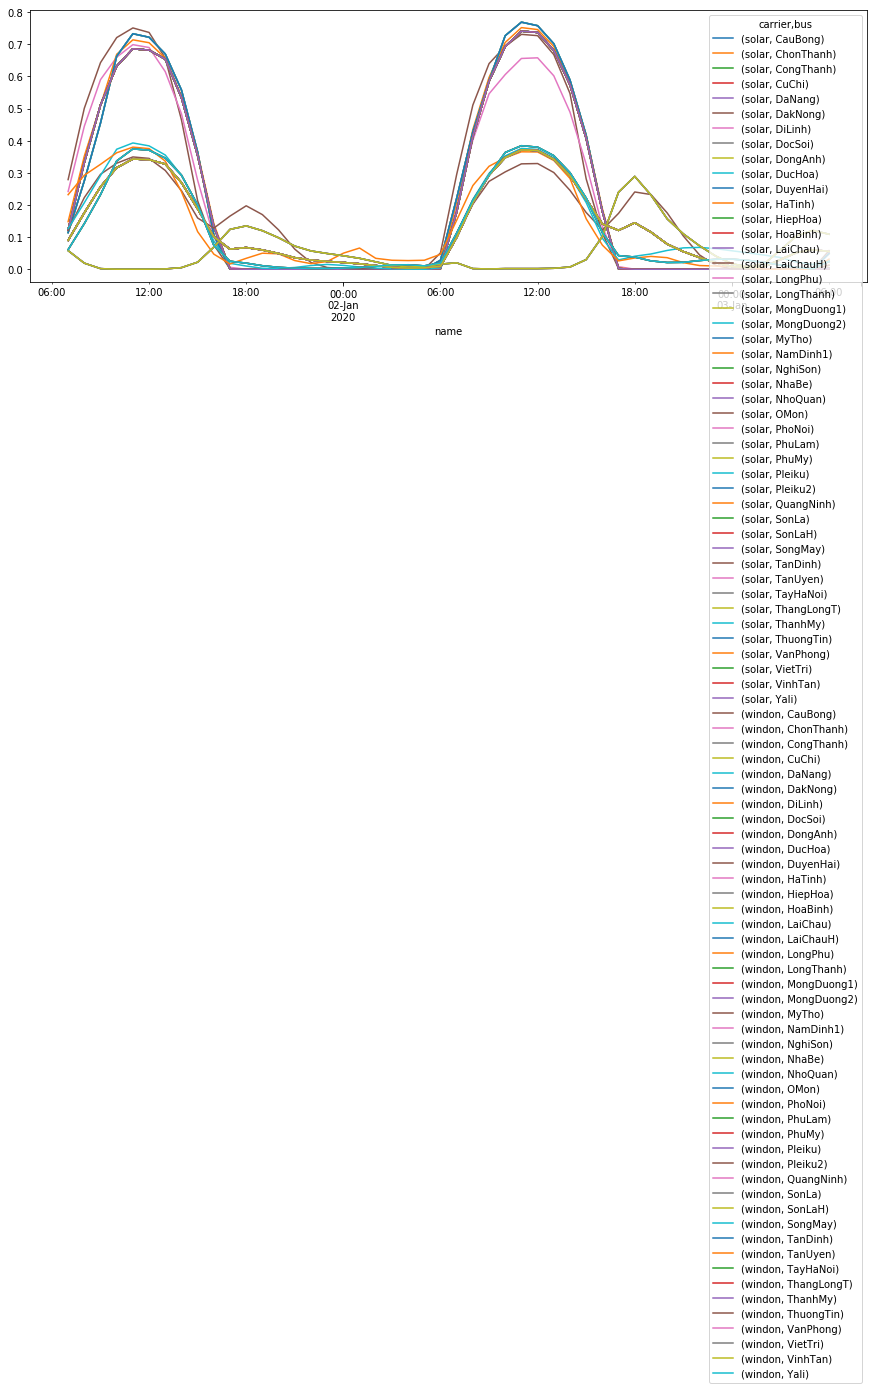

In [6]:
fig, ax = plt.subplots(figsize=(15,5))

network.generators_t.p_max_pu.groupby([network.generators.carrier, network.generators.bus], axis=1).mean().iloc[0:48] \
       .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).drop(columns='hydro').plot(ax=ax)

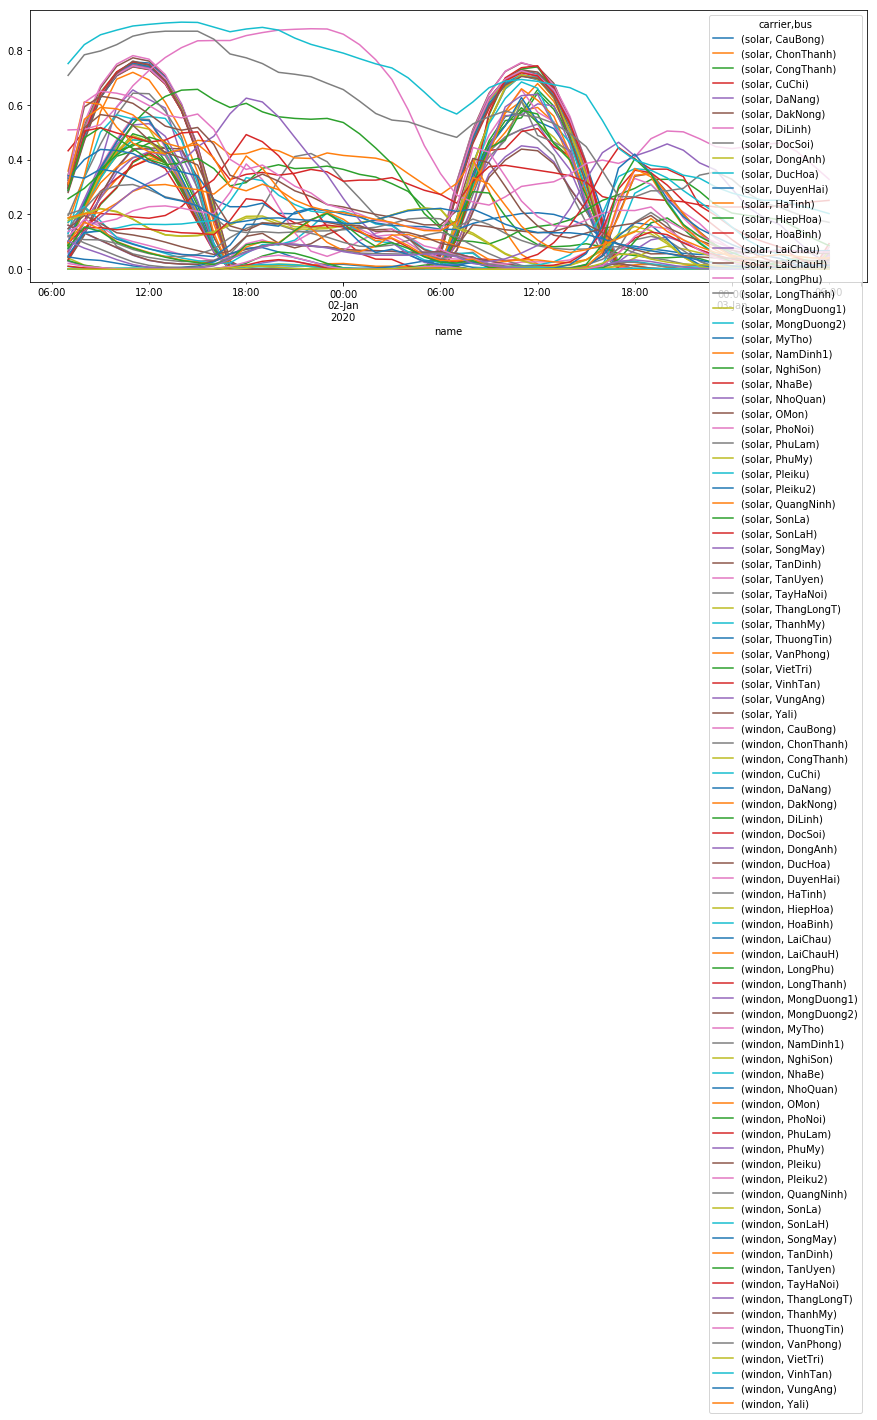

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

ninja.generators_t.p_max_pu.groupby([ninja.generators.carrier, ninja.generators.bus], axis=1).mean().iloc[0:48] \
     .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).plot(ax=ax)

## Test Optimisation

In [8]:
network.add("GlobalConstraint","co2_limit",sense="<=",constant=1) #constraint for CO2 emission limit
network.loads_t.p_set = network.loads_t.p_set.fillna(0.)

In [9]:
ninja.add("GlobalConstraint","co2_limit",sense="<=",constant=1) #constraint for CO2 emission limit
ninja.loads_t.p_set = ninja.loads_t.p_set.fillna(0.)

In [10]:
#runlopf
network.generators.loc[network.generators.carrier=='hydro', 'p_nom_extendable'] = False
network.generators.loc[network.generators.carrier=='hydro', 'p_nom_max'] = 2e3
network.global_constraints.loc['co2_limit','constant'] = 50e4
network.lopf(network.snapshots[:100],solver_name='gurobi',keep_files=False,solver_options={'threads':8}) #full year

INFO:pypsa.pf:Slack bus for sub-network 0 is HiepHoa
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x29301_copy
  Lower bound: 15748440674.1
  Upper bound: 15748440674.1
  Number of objectives: 1
  Number of constraints: 51202
  Number of variables: 29301
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 29301
  Number of nonzeros: 119136
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

('ok', 'optimal')

In [11]:
#runlopf
ninja.generators.loc[ninja.generators.carrier=='hydro', 'p_nom_extendable'] = False
ninja.generators.loc[ninja.generators.carrier=='hydro', 'p_nom_max'] = 2e3
ninja.global_constraints.loc['co2_limit','constant'] = 50e4
ninja.lopf(ninja.snapshots[:100],solver_name='gurobi',keep_files=False,solver_options={'threads':8}) #full year

INFO:pypsa.pf:Slack bus for sub-network 0 is HiepHoa
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x29704_copy
  Lower bound: 3649419746.95
  Upper bound: 3649419746.95
  Number of objectives: 1
  Number of constraints: 51802
  Number of variables: 29704
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 29704
  Number of nonzeros: 120072
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

('ok', 'optimal')

(<matplotlib.collections.PatchCollection at 0x7f518c10ab50>,
 <matplotlib.collections.LineCollection at 0x7f5187b97590>)

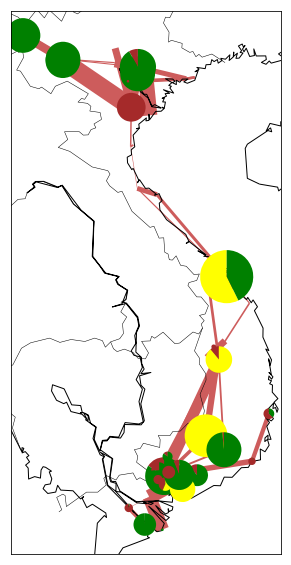

In [12]:
capas = network.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = network.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)

capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]

plotcapas = capas
plotlines = lines

fig, ax = plt.subplots(1,1, figsize=(10,10))

bus_scale = 1e5
link_scale = 5e2

colors = dict(zip(['OCGT','windon','hydro','solar'],
                  ['brown','green','blue','yellow']))

network.plot(bus_sizes=plotcapas/bus_scale, bus_colors=colors, ax=ax,
             line_widths={'Link':0.0, 'Line':plotlines/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'})

(<matplotlib.collections.PatchCollection at 0x7f518c401990>,
 <matplotlib.collections.LineCollection at 0x7f51874828d0>)

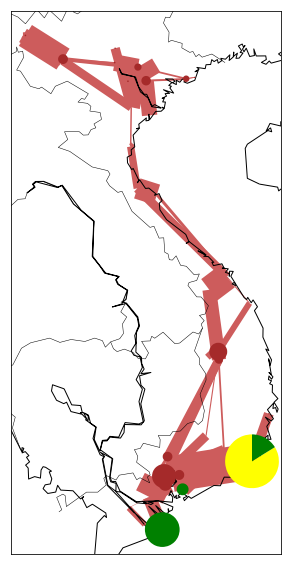

In [13]:
capas = ninja.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = ninja.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)

capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]

plotcapas = capas
plotlines = lines

fig, ax = plt.subplots(1,1, figsize=(10,10))

bus_scale = 1e5
link_scale = 5e2

colors = dict(zip(['OCGT','windon','hydro','solar'],
                  ['brown','green','blue','yellow']))

ninja.plot(bus_sizes=plotcapas/bus_scale, bus_colors=colors, ax=ax,
             line_widths={'Link':0.0, 'Line':plotlines/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'})

## Add 'Realistic' Line Costs

In [26]:
#runlopf
network.generators.loc[network.generators.carrier=='hydro', 'p_nom_extendable'] = False
network.generators.loc[network.generators.carrier=='hydro', 'p_nom_max'] = 2e3
network.global_constraints.loc['co2_limit','constant'] = 50e4
network.lines['capital_cost'] = network.lines['length'] * 100
network.lopf(network.snapshots[:100],solver_name='gurobi',keep_files=False,solver_options={'threads':8}) #full year

INFO:pypsa.pf:Slack bus for sub-network 0 is HiepHoa
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x29301_copy
  Lower bound: 17691449777.5
  Upper bound: 17691449777.5
  Number of objectives: 1
  Number of constraints: 51202
  Number of variables: 29301
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 29301
  Number of nonzeros: 119136
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

('ok', 'optimal')

(<matplotlib.collections.PatchCollection at 0x7f51b9f364d0>,
 <matplotlib.collections.LineCollection at 0x7f51bc486250>)

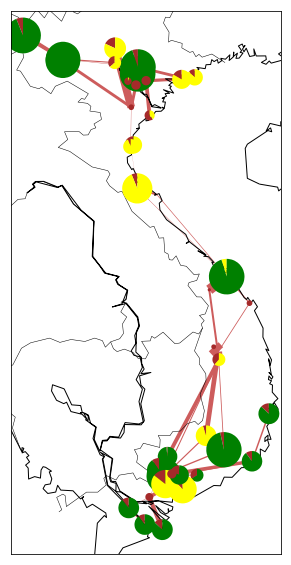

In [27]:
capas = network.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = network.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)

capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]

plotcapas = capas
plotlines = lines

fig, ax = plt.subplots(1,1, figsize=(10,10))

bus_scale = 1e5
link_scale = 5e2

colors = dict(zip(['OCGT','windon','hydro','solar'],
                  ['brown','green','blue','yellow']))

network.plot(bus_sizes=plotcapas/bus_scale, bus_colors=colors, ax=ax,
             line_widths={'Link':0.0, 'Line':plotlines/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'})

In [24]:
#runlopf
ninja.generators.loc[ninja.generators.carrier=='hydro', 'p_nom_extendable'] = False
ninja.generators.loc[ninja.generators.carrier=='hydro', 'p_nom_max'] = 2e3
ninja.global_constraints.loc['co2_limit','constant'] = 50e4
ninja.lines['capital_cost'] = ninja.lines['length'] * 100
ninja.lopf(ninja.snapshots[:100],solver_name='gurobi',keep_files=False,solver_options={'threads':8}) #full year

INFO:pypsa.pf:Slack bus for sub-network 0 is HiepHoa
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x29704_copy
  Lower bound: 4646315599.15
  Upper bound: 4646315599.15
  Number of objectives: 1
  Number of constraints: 51802
  Number of variables: 29704
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 29704
  Number of nonzeros: 120072
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: 

('ok', 'optimal')

(<matplotlib.collections.PatchCollection at 0x7f51b0815790>,
 <matplotlib.collections.LineCollection at 0x7f518e782150>)

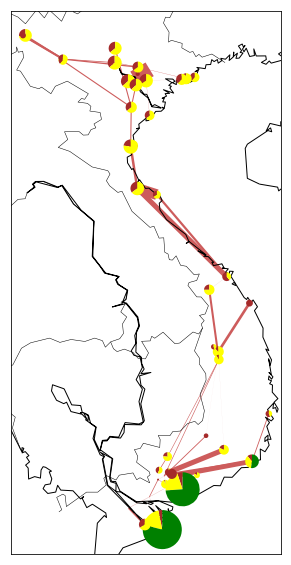

In [25]:
capas = ninja.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = ninja.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)

capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]

plotcapas = capas
plotlines = lines

fig, ax = plt.subplots(1,1, figsize=(10,10))

bus_scale = 1e5
link_scale = 5e2

colors = dict(zip(['OCGT','windon','hydro','solar'],
                  ['brown','green','blue','yellow']))

ninja.plot(bus_sizes=plotcapas/bus_scale, bus_colors=colors, ax=ax,
             line_widths={'Link':0.0, 'Line':plotlines/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'})

## Total Costs

In [32]:
network.objective / 1e9

17.6914497775

In [33]:
ninja.objective / 1e9

4.646315599149999